## Stock market prediction

In [570]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
%matplotlib inline
import math
import statsmodels.api as sm
import talib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [571]:
# import SPY 10 years of data to the most recent date in 2021. 
# SPY is designed to track the S&P 500 stock market index. This fund is the largest ETF in the world. 
df = web.DataReader('SPY', data_source='yahoo', start='2010-01-01', end='2021-02-19')

## Exporatory Data Analysis

In [572]:
df.tail() # examine the stock data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-12,392.899994,389.769989,389.850006,392.640015,50505700.0,392.640015
2021-02-16,394.170013,391.529999,393.959991,392.299988,50700800.0,392.299988
2021-02-17,392.660004,389.329987,390.420013,392.390015,52290600.0,392.390015
2021-02-18,391.519989,387.739990,389.589996,390.720001,59552200.0,390.720001
2021-02-19,392.380005,389.549988,392.070007,390.029999,83142800.0,390.029999


In [573]:
df.shape # get the number of rows and columns

(2802, 6)

In [574]:
df.describe() # generate descriptive statistics

,High,Low,Open,Close,Volume,Adj Close
count,2802.000000,2802.000000,2802.000000,2802.000000,2.802000e+03,2802.000000
mean,210.783105,208.517659,209.704789,209.734333,1.237649e+08,192.583213
std,69.809154,69.075299,69.468840,69.454677,7.465493e+07,75.348641
min,103.419998,101.129997,103.110001,102.199997,2.027000e+07,82.872505
25%,142.442497,141.355003,141.982498,141.982498,7.239802e+07,120.491968
50%,206.800003,204.629997,205.614998,205.614998,1.038480e+08,184.856987
75%,268.587502,265.575005,267.577507,267.287506,1.530642e+08,254.170013
max,394.170013,391.529999,393.959991,392.640015,7.178287e+08,392.640015


In [575]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2802 entries, 2010-01-04 to 2021-02-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2802 non-null   float64
 1   Low        2802 non-null   float64
 2   Open       2802 non-null   float64
 3   Close      2802 non-null   float64
 4   Volume     2802 non-null   float64
 5   Adj Close  2802 non-null   float64
dtypes: float64(6)
memory usage: 153.2 KB


In [576]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2021-02-05', '2021-02-08', '2021-02-09', '2021-02-10',
               '2021-02-11', '2021-02-12', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19'],
              dtype='datetime64[ns]', name='Date', length=2802, freq=None)

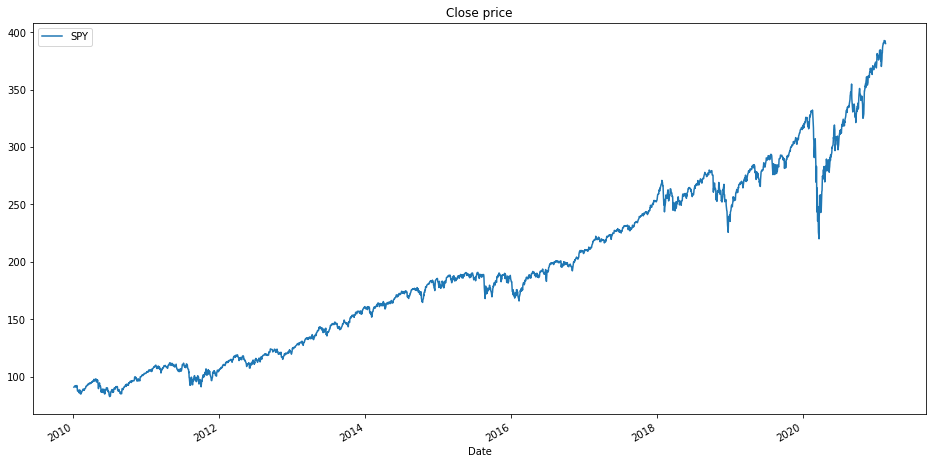

In [577]:
# plot the closing price
df['Adj Close'].plot(label='SPY', figsize=(16,8), title='Close price')
plt.legend();

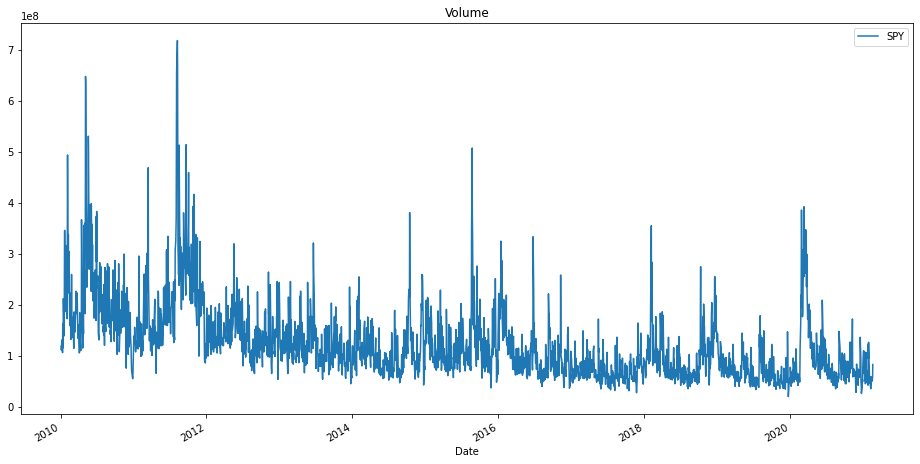

In [578]:
# plot the volume
df['Volume'].plot(label='SPY', figsize=(16,8), title='Volume')
plt.legend();

#### SPY has a huge volume in 2011. Let's find out the exact date of this event to see what happend that date

In [579]:
df['Volume'].idxmax()

Timestamp('2011-08-09 00:00:00')

#### The event was on Black Monday when US and global stock markets crashed.

<AxesSubplot:xlabel='Date'>

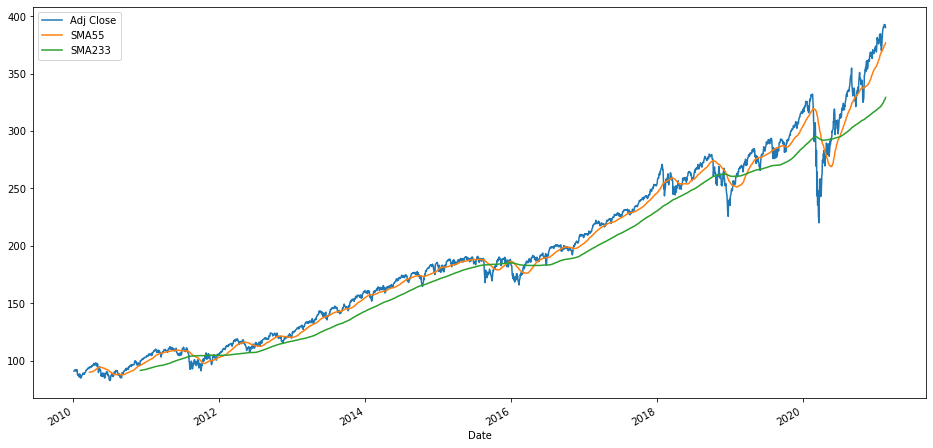

In [580]:
# plot the simple moving average (SMA)
df['SMA55'] = df['Adj Close'].rolling(55).mean()
df['SMA233'] = df['Adj Close'].rolling(233).mean()
df[['Adj Close', 'SMA55', 'SMA233']].plot(figsize=(16,8))

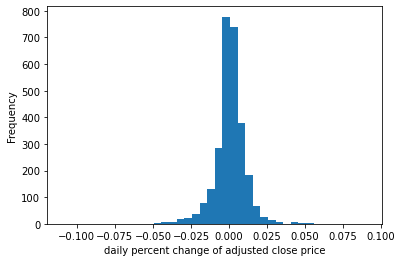

In [581]:
# histogram of the daily price change percent of the closing price
df['Adj Close'].pct_change().plot.hist(bins=40)
plt.xlabel('daily percent change of adjusted close price')
plt.show()

## Correlation coefficient
#### Check how strong is the correlation of previous price changes vs future price changes. If it's highly correlated, then the stock price is trend following. Otherwise, the stock price is mean-reverting.

            Current Adj Close Percent  Future Adj Close Percent
Date                                                           
2010-01-04                        NaN                       NaN
2010-01-05                        NaN                       NaN
2010-01-06                        NaN                       NaN
2010-01-07                        NaN                       NaN
2010-01-08                        NaN                       NaN
...                               ...                       ...
2021-02-12                   0.012716                 -0.006647
2021-02-16                   0.004584                 -0.005786
2021-02-17                   0.005484                 -0.006014
2021-02-18                   0.001641                 -0.001766
2021-02-19                  -0.001740                  0.000000

[2802 rows x 2 columns]


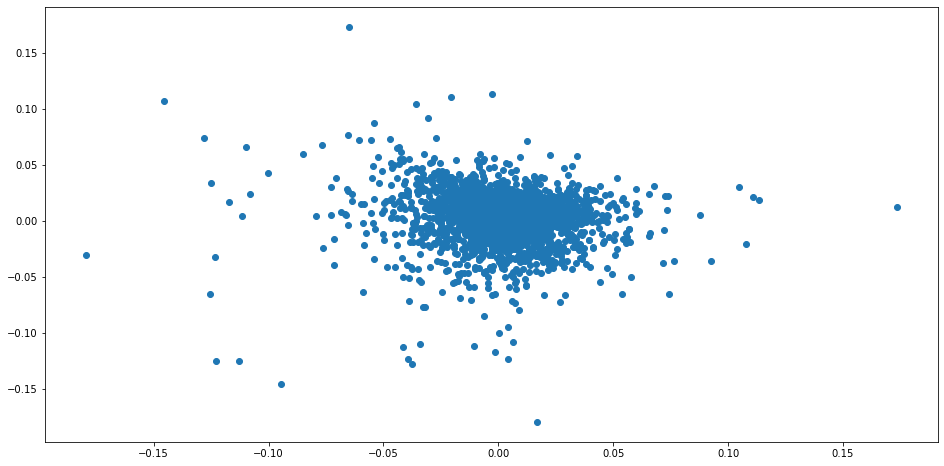

In [582]:
trading_period = 5 # define the trading period to calculate the correlation

df['Future Adj Close'] = df['Adj Close'].shift(-5) # create a new future price of the next 5 trading days
df['Future Adj Close Percent'] = df['Future Adj Close'].pct_change(trading_period) # Future price change percentage
df['Current Adj Close Percent'] = df['Adj Close'].pct_change(trading_period) # Current price change percentage

corr = df[['Current Adj Close Percent', 'Future Adj Close Percent']]
print(corr)

# plot the correlation
plt.figure(figsize=(16,8))
plt.scatter(df['Current Adj Close Percent'], df['Future Adj Close Percent'])

In [583]:
df['Current Adj Close Percent']

Date
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
                ...   
2021-02-12    0.012716
2021-02-16    0.004584
2021-02-17    0.005484
2021-02-18    0.001641
2021-02-19   -0.001740
Name: Current Adj Close Percent, Length: 2802, dtype: float64

#### We can see the future price change is negatively correlated to the previous price change for a 5 days trading period. This tells us that a mean reversion trading would be a good trading strategy.

## Feature Engineering
#### We want to add more data to the machinee learning models to make better prediction. We will add the new features below:

#### 1. Adding  simple moving averages and RSI (Relative Strength Index) for different time period

In [584]:
new_features = ['Current Adj Close Percent']

# time preiods using numbers in the Fibonacci Sequence
# time_periods = [55, 89, 144, 233] 
time_periods = [21, 89, 377, 1597] # Tried different time periods to get better correlations between the features and targets in the steps below

for n in time_periods:

    # Create the moving average indicator and divide by Adj_Close
    df['sma' + str(n)] = talib.SMA(df['Adj Close'].values,
                              timeperiod=n) / df['Adj Close']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    new_features = new_features + ['sma' + str(n), 'rsi' + str(n)]

print(new_features)

['Current Adj Close Percent', 'sma21', 'rsi21', 'sma89', 'rsi89', 'sma377', 'rsi377', 'sma1597', 'rsi1597']


In [585]:
df = df.dropna()
features = df[new_features]
targets = df['Future Adj Close Percent']

# create a new DataFrame from the target column and the new features columns
cols = ['Future Adj Close Percent'] + new_features
new_df = df[cols]

# Calculate correlation matrix
corr = new_df.corr()
print(corr)

                           Future Adj Close Percent  \
Future Adj Close Percent                   1.000000   
Current Adj Close Percent                 -0.008448   
sma21                                      0.020116   
rsi21                                     -0.077737   
sma89                                      0.137758   
rsi89                                     -0.122127   
sma377                                     0.182958   
rsi377                                    -0.179864   
sma1597                                    0.207833   
rsi1597                                   -0.219794   

                           Current Adj Close Percent     sma21     rsi21  \
Future Adj Close Percent                   -0.008448  0.020116 -0.077737   
Current Adj Close Percent                   1.000000 -0.732712  0.480452   
sma21                                      -0.732712  1.000000 -0.661024   
rsi21                                       0.480452 -0.661024  1.000000   
sma89         

<AxesSubplot:>

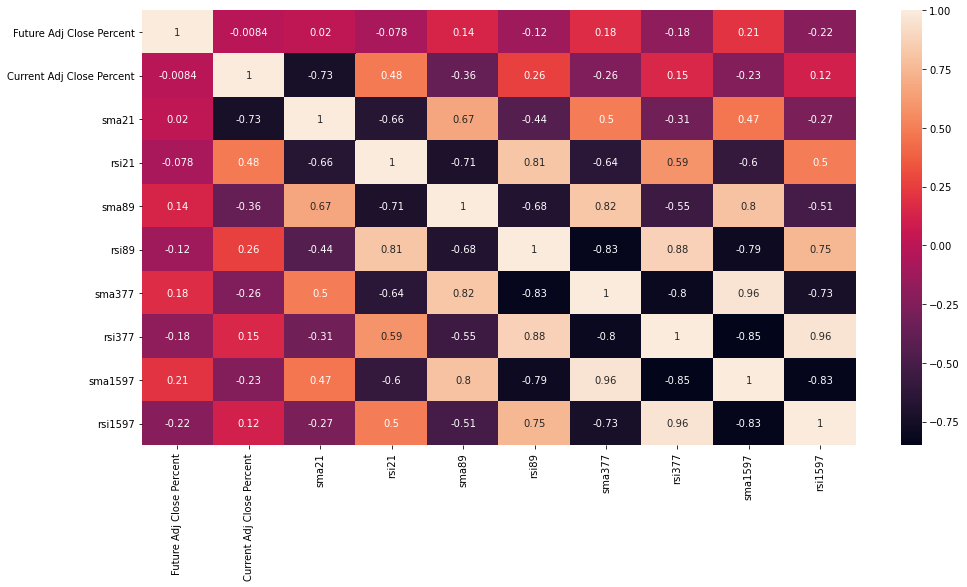

In [586]:
# plot the heatmap to see the correlations between the features and targets
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr, annot=True, ax=ax)

In [587]:
features.shape

(1200, 9)

In [588]:
# Create train and test set
# With financial time series data, we want to use the old data for our training set and the new data for our test set. 
# This would help us to validate the model performance on the most recent stock price.
features = sm.add_constant(features)

# Feature scaling
# scaler = MinMaxScaler(feature_range=(0,1))
# traing_set_scaled = scaler.fit_transform(features)

# Use 80% of the total samples for the training set
train_size = int(0.80 * features.shape[0])

X_train = features[:train_size]
y_train = targets[:train_size]

X_test = features[train_size:]
y_test = targets[train_size:]
print(features.shape, X_train.shape, X_test.shape)

(1200, 10) (960, 10) (240, 10)


#### 2. Adding a simple moving average (SMA) which is one of the most common indicators.

<AxesSubplot:ylabel='Frequency'>

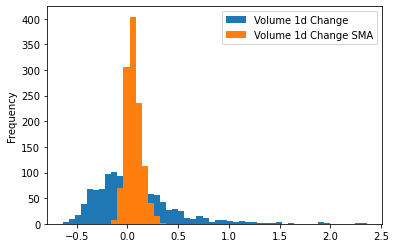

In [589]:
volume_features = ['Volume 1d Change', 'Volume 1d Change SMA']
new_features.extend(volume_features)

# new feature - volumne change percentage in 1 day
df['Volume 1d Change'] = df['Volume'].pct_change(1)

# new feature - 8 day moving average of the 1 day percent change in volume
df['Volume 1d Change SMA'] = talib.SMA(df['Volume 1d Change'].values, timeperiod=8)

df[volume_features].plot(kind='hist', sharex=False, bins=50)

#### 3. Adding a day of the week feature

In [590]:
days_of_week = pd.get_dummies(df.index.dayofweek,
                             prefix='Day of Week',
                             drop_first=True)

days_of_week.index = df.index
# join the data frame
df = pd.concat([df, days_of_week], axis=1)

# add days of week to the list of new features
new_features.extend(['Day of Week_' + str(n) for n in range(1, 5)] )
# drop missing value
df.dropna(inplace=True)

df.head()


,High,Low,Open,Close,Volume,Adj Close,SMA55,SMA233,Future Adj Close,Future Adj Close Percent,...,sma377,rsi377,sma1597,rsi1597,Volume 1d Change,Volume 1d Change SMA,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-19,204.539993,202.779999,204.059998,204.199997,115430500.0,186.357086,187.145827,183.055119,191.047989,0.025172,...,0.986314,52.013592,0.741214,53.192354,-0.038577,0.070260,0,0,1,0
2016-05-20,206.100006,204.860001,204.919998,205.490005,104990400.0,187.534409,187.257584,183.043980,191.869370,0.023116,...,0.980207,52.145731,0.736882,53.229469,-0.090445,0.053749,0,0,0,1
2016-05-23,205.839996,204.990005,205.509995,205.210007,58682600.0,187.278870,187.353964,183.035366,191.504318,0.022562,...,0.981621,52.114500,0.738204,53.220304,-0.441067,-0.008249,0,0,0,0
2016-05-24,208.240005,206.139999,206.169998,207.869995,93537800.0,189.706421,187.491840,183.033009,191.896759,0.011546,...,0.969155,52.386123,0.729082,53.296742,0.593961,0.053975,1,0,0,0
2016-05-25,209.770004,207.869995,208.669998,209.279999,76621400.0,190.993210,187.689264,183.035596,192.480804,0.007789,...,0.962732,52.529237,0.724502,53.337185,-0.180851,0.021758,0,1,0,0


## Correlation coefficient of the new features

#### Check how strong is the correlation of the new features with the target "Future Close Percent" feature

<AxesSubplot:>

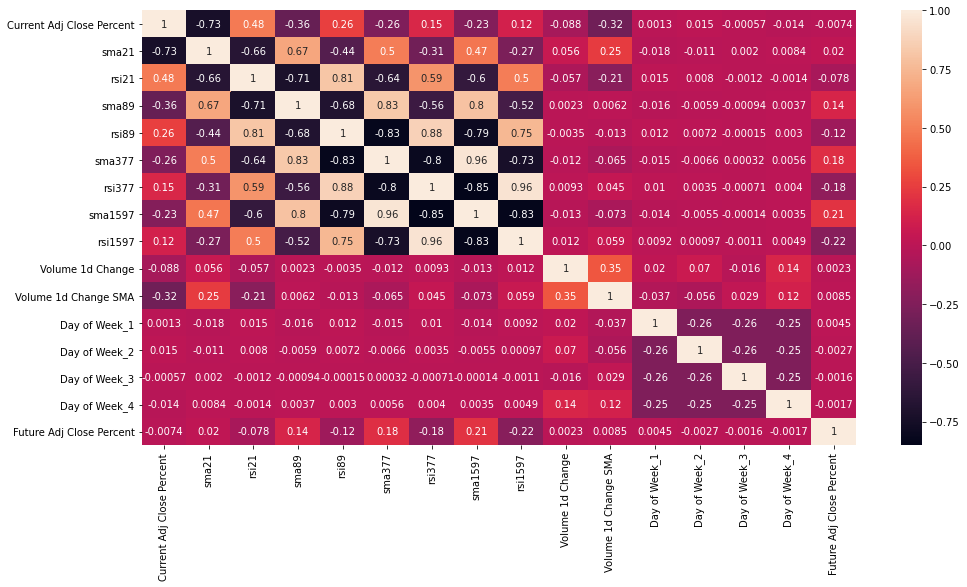

In [591]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df[new_features + ['Future Adj Close Percent']].corr(), annot=True, ax=ax)

#### We can see the correlations are weak, but they may still improve our non-linear model predictions by interacting with other features. 

## Random Forest

In [592]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9062392715743491
-0.5719917884306198


In [593]:
# Tune the hyperparameter to improve the test score
from sklearn.model_selection import ParameterGrid as pg

params = {'n_estimators':[500], 'max_depth':[2], 'max_features':[4,10], 'random_state':[40]}
test_scores = []

for i in pg(params):
    rf.set_params(**i)
    rf.fit(X_train, y_train)
    test_scores.append(rf.score(X_test, y_test))

best_score = np.argmax(test_scores)
print(test_scores[best_score], pg(params)[best_score])

-0.059524407404227375 {'random_state': 40, 'n_estimators': 500, 'max_features': 4, 'max_depth': 2}


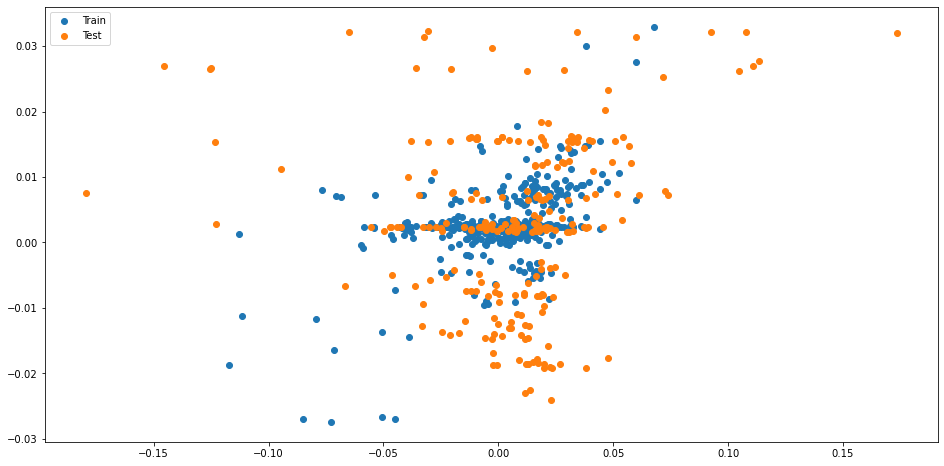

In [594]:
# Check the model performance

# fit the model with the best hyperparameter we found above
rf = RandomForestRegressor(n_estimators=500, max_depth=2, max_features=4, random_state=40)
rf.fit(X_train, y_train)

train_predict = rf.predict(X_train)
test_predict = rf.predict(X_test)

plt.figure(figsize=(16,8))
plt.scatter(y_train, train_predict, label='Train')
plt.scatter(y_test, test_predict, label='Test')
plt.legend()
plt.show()

In [595]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## Neural Network

In [596]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

nn = Sequential()
nn.add(Dense(200, input_dim=X_train_scale.shape[1], activation='relu'))
nn.add(Dropout(0.2)) # add dropout to prevent overfitting
nn.add(Dense(50, activation='relu'))
nn.add(Dense(1, activation='linear'))

# fit the neural network model with a mean squared error loss function
nn.compile(optimizer='adam', loss='mse')
history = nn.fit(X_train_scale, y_train, epochs=30)

Epoch 1/30
960/960 [==============================] - 1s 738us/step - loss: 0.0189
Epoch 2/30
960/960 [==============================] - 0s 99us/step - loss: 0.0089
Epoch 3/30
960/960 [==============================] - 0s 104us/step - loss: 0.0056
Epoch 4/30
960/960 [==============================] - 0s 106us/step - loss: 0.0038
Epoch 5/30
960/960 [==============================] - 0s 106us/step - loss: 0.0030
Epoch 6/30
960/960 [==============================] - 0s 106us/step - loss: 0.0027
Epoch 7/30
960/960 [==============================] - 0s 106us/step - loss: 0.0023
Epoch 8/30
960/960 [==============================] - 0s 108us/step - loss: 0.0017
Epoch 9/30
960/960 [==============================] - 0s 107us/step - loss: 0.0016
Epoch 10/30
960/960 [==============================] - 0s 106us/step - loss: 0.0014
Epoch 11/30
960/960 [==============================] - 0s 108us/step - loss: 0.0014
Epoch 12/30
960/960 [==============================] - 0s 110us/step - loss: 0.0013
Ep

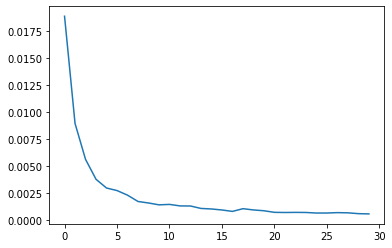

In [597]:
# check if the loss curve is flattened out to see if the neural net is sufficiently trained
plt.plot(history.history['loss'])

## Neural Network Model Performance

-0.6066821374793427
-0.48706220744139594


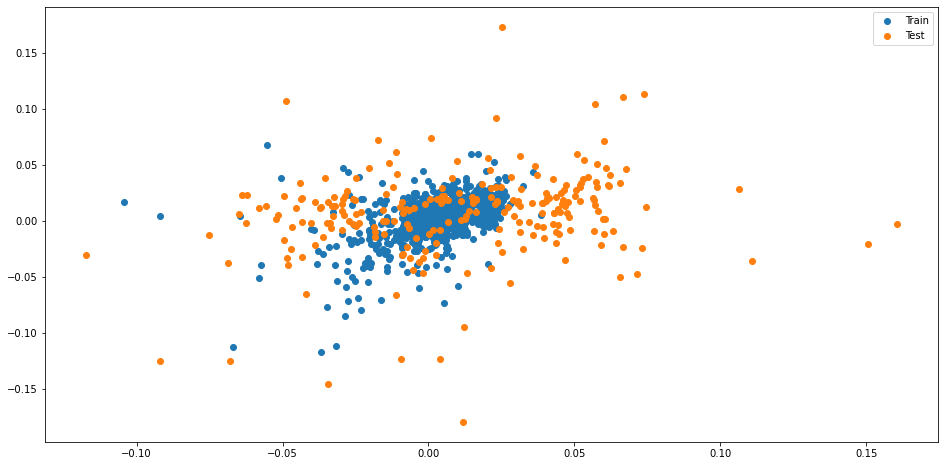

In [598]:
from sklearn.metrics import r2_score

train_predict_nn = nn.predict(X_train_scale)
test_predict_nn = nn.predict(X_test_scale)

print(r2_score(train_predict_nn, y_train))
print(r2_score(test_predict_nn, y_test))

plt.figure(figsize=(16,8))
plt.scatter(train_predict_nn, y_train, label='Train')
plt.scatter(test_predict_nn, y_test, label='Test')
plt.legend()
plt.show()

## Create a custom loss function to add penalty

In [599]:
import keras.losses
import tensorflow as tf

def custom_loss(true_val, predict_val):
    penalty = 500
    loss = tf.where(tf.less(true_val * predict_val, 0), penalty * tf.square(true_val - predict_val), tf.square(true_val - predict_val))
    
    return tf.reduce_mean(loss, axis=-1)

keras.losses.custom_loss = custom_loss

## 2nd Neural Network with the custom loss function

In [600]:
nn2 = Sequential()
nn2.add(Dense(500, input_dim=X_train_scale.shape[1], activation='relu'))
#nn2.add(Dropout(0.25)) # add dropout to prevent overfitting
nn2.add(Dense(50, activation='relu'))
nn2.add(Dense(1, activation='linear'))

# fit the neural network model with a mean squared error loss function
nn2.compile(optimizer='adam', loss=custom_loss) # use the custom loss function instead of sme from the previous model
history = nn2.fit(X_train_scale, y_train, epochs=30)

Epoch 1/30
960/960 [==============================] - 1s 662us/step - loss: 1.9500
Epoch 2/30
960/960 [==============================] - 0s 113us/step - loss: 1.2113
Epoch 3/30
960/960 [==============================] - 0s 118us/step - loss: 0.3131
Epoch 4/30
960/960 [==============================] - 0s 119us/step - loss: 0.1177
Epoch 5/30
960/960 [==============================] - 0s 119us/step - loss: 0.0774
Epoch 6/30
960/960 [==============================] - 0s 120us/step - loss: 0.0713
Epoch 7/30
960/960 [==============================] - 0s 117us/step - loss: 0.0885
Epoch 8/30
960/960 [==============================] - 0s 120us/step - loss: 0.0531
Epoch 9/30
960/960 [==============================] - 0s 122us/step - loss: 0.0536
Epoch 10/30
960/960 [==============================] - 0s 123us/step - loss: 0.0632
Epoch 11/30
960/960 [==============================] - 0s 121us/step - loss: 0.0813
Epoch 12/30
960/960 [==============================] - 0s 118us/step - loss: 0.1666
E

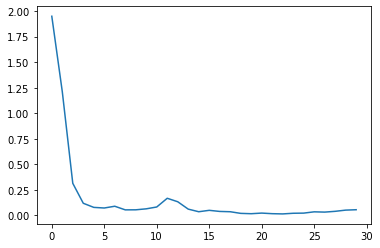

In [601]:
# check if the loss curve is flattened out to see if the neural net is sufficiently trained
plt.plot(history.history['loss'])

## 2nd Neural Network Model Performance

-1.3679893187634766
-0.29260031074236004


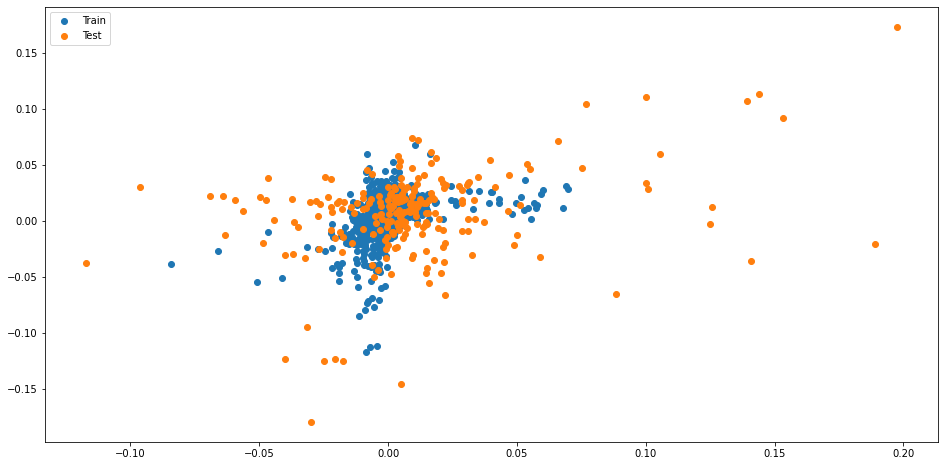

In [602]:
from sklearn.metrics import r2_score

train_predict_nn2 = nn2.predict(X_train_scale)
test_predict_nn2 = nn2.predict(X_test_scale)

print(r2_score(train_predict_nn2, y_train))
print(r2_score(test_predict_nn2, y_test))

plt.figure(figsize=(16,8))
plt.scatter(train_predict_nn2, y_train, label='Train')
plt.scatter(test_predict_nn2, y_test, label='Test')
plt.legend()
plt.show()

## Ensembling 1st and 2nd Neural Network Model

In [603]:
ensembling_train_predict = np.mean(np.hstack((train_predict_nn, train_predict_nn2)), axis=1)
ensembling_test_predict = np.mean(np.hstack((test_predict_nn, test_predict_nn2)), axis=1)

## Ensembling Model Performance

-1.257762666961324
-0.5796675982504489


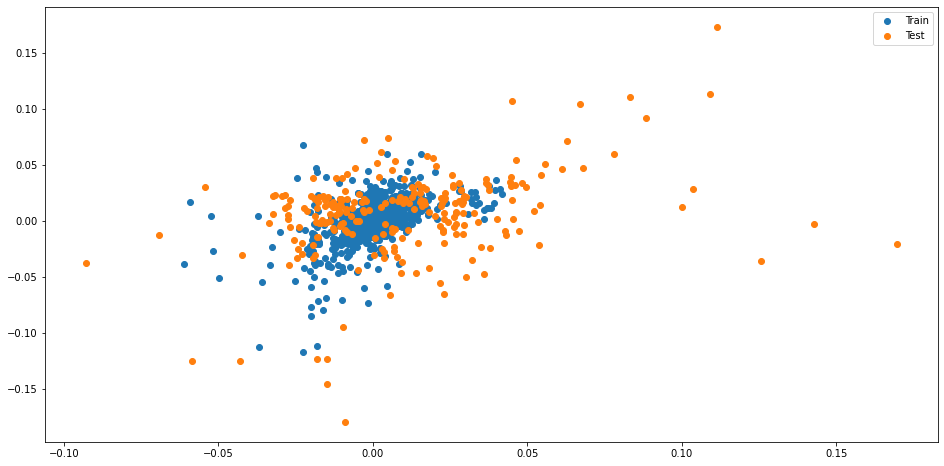

In [604]:
from sklearn.metrics import r2_score

print(r2_score(ensembling_train_predict, y_train))
print(r2_score(ensembling_test_predict, y_test))

plt.figure(figsize=(16,8))
plt.scatter(ensembling_train_predict, y_train, label='Train')
plt.scatter(ensembling_test_predict, y_test, label='Test')
plt.legend()
plt.show()

#### We can see the r2_score values are about the average of both models